## Uniform Swarming Simulator

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of the idealized case of a perfectly simulation of bacterial swarming. This solves the ideal case where there is no spatial heterogeneity in the initial nutrient concentration in the system, allowing to avoid needing to resolve the individual branches areas tensor. Additionally, we also treat the system with periodic boundary conditions for simplicity and solve the nutrient PDE pseudospectrally.

We begin by importing all dependencies of interest. 

In [1]:
# Import numerical jax dependencies
import jax
from jax import numpy as jnp

# For readability. 
from collections import namedtuple

# Import plotting dependencies
import matplotlib.pyplot as plt
from jax_tqdm import scan_tqdm
from IPython.display import clear_output

/home/users/ymb8/Jax/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we will define all our immutable simulation parameters up front. These can be easily adjusted throughout the course of the simulation as needed. 

In [2]:
# First define the parameters related to the branching parameters of the system. 
width = 4 # The width of an individual branch
w = width
density = 0.15 # The critical branching density, after which a pattern will split. 

# Next we define global variables related to the initial distribution of nutrients in the system and the energy coefficient of expansion
N0 = 8
gamma = 7.5 # The constant colony expansion efficiency; a measure of how much energy is needed to extend a branch basically

Next we will define the parameters of the PDE, including the spatial domain of the system simulation in both physical and wavenumber space. 

In [54]:
# Define geometry of simulation in time and space. 
L = 90 # Length of side of domain. 
totalT = 24 # Simulation time length
dt = 0.02 # Integration time step
nt = int(totalT/dt) # Number of time steps

# Define the number of nodes of the simualtion. 
nx = 1000 # Number of grid points
ny = nx # Number of grid points
dx = L / nx # Grid spacing
dy = dx # Grid spacing

# Create a FD grid
x = jnp.arange(-L/2, L/2,dx)
y = jnp.arange(-L/2, L/2,dy)
XX, YY = jnp.meshgrid(x, y)
RR = jnp.sqrt(XX**2 + YY**2)

# Create an analogous fourier transform of the grid for use in solving the diffusion PDE. 
kx = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)
ky = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)

KX, KY = jnp.meshgrid(kx, ky)
K = jnp.sqrt(KX**2 + KY**2)

Now we fix the parameters associated to the pharmokinetics of the system. For a full description of the meaning of these model parameters, see the original Luo et. al paper from MSB. 

In [55]:
bN = 160. # beta uptake constant
DN = 9.; # Diffusion constant 
aC = 1.2; # alpha elongation efficiency constant
KN = 0.8; # half saturation for nutrient uptake kinetcs
Cm = 0.05; # Half saturation for cell density in monod model. 
r0 = 5.0 # Initial radius of our colony inocculation point
c0 = 1.6 # Initial total number of cells in our system measured in a.u. 

Now we define the first of our jax pure functions to handle updating the state of the system. This specific function will intake the current distribution of the nutrients in the system as well as the current distribution of cells and update the nutrient by numerically solving the reaction-diffusion PDE. 

In [56]:
def pde_update(pde_state, x):
    # First we need to unpack the PDE state for the nutrient and cell biomass distribution of the system
    N, C, P = pde_state

    # First, we compute our reaction term to see how much growth the system will undergo
    fN = N / (N + KN) * Cm / (C + Cm) * C
    dN = -bN*fN
    dN_hat = jnp.fft.fft2(dN)

    # Now we solve for the reaction diffusion PDE via fourier space CN timestepping
    N_hat = jnp.fft.fft2(N)
    pre_factor  = (1 + 0.5*DN*(K**2)*dt)**(-1)
    post_factor = (1 - 0.5*DN*(K**2)*dt)
    N_new = jnp.fft.ifft2(pre_factor*(post_factor*N_hat + dN_hat*dt)).real

    #--- Update cell density state ---#
    dC = aC * fN
    C_new = C + dC*dt

    return (N_new,C_new, P), None

Now we'll define a utility function in Jax to compute the PSD between the given set of coordinates. This will be used to assess the density of individual branches to determine bifurcation. 

In [57]:
def pairwise_distances(coordinates):
    # Calculate squared distances between all pairs of coordinates
    squared_distances = jnp.sum((coordinates[:, None] - coordinates) ** 2, axis=-1)
    # Take the square root to get the actual distances
    distances = jnp.sqrt(squared_distances)
    return distances

Now we will define the subroutines that will be used in updating the values of the system during the simulation. We have already defined the solver for the PDE step of the system, we will now consider subroutines for initializing and updating the branching tip agents throughout the course of the simulation. 

In [58]:
def init_swarm(num_init_branches, max_tips):
    swarm_array = jnp.zeros((2*max_tips+2, 3))
    swarm_mask = jnp.zeros(2*max_tips+2)
    start_layer = jnp.ceil(jnp.log2(num_init_branches))
    start_index = jnp.power(2,start_layer).astype(jnp.int32)

    # Initialize the swarm array positions and angles
    theta0 = jnp.linspace(jnp.pi/2, jnp.pi/2 + 2*jnp.pi, num_init_branches+1)[:-1]
    swarm_array = swarm_array.at[start_index:start_index+num_init_branches,2].set(theta0)
    swarm_array = swarm_array.at[start_index:start_index+num_init_branches,1].set( r0*jnp.sin(theta0) )
    swarm_array = swarm_array.at[start_index:start_index+num_init_branches,0].set( r0*jnp.cos(theta0) )
    
    swarm_mask = swarm_mask.at[start_index:start_index+num_init_branches].set(1)
    return swarm_array, swarm_mask 
    
coords, mask = init_swarm(5, 64)

In [59]:
def init_pde(C0, N0, R0):
    """Initialize the PDE parameters for the system."""
    
    N = jnp.zeros((nx, ny)) + N0
    P = (RR < R0).astype(jnp.int32)
    C = C0/( jnp.sum(P) * nx * ny)*(P)
    n_tips0 = max(jnp.ceil(2 * jnp.pi * r0 * density),2)

    return (N, C, P), n_tips0

In [60]:
# definition of branch computation logic
def branch_update(swarm_state):

    swarm_array, swarm_mask = swarm_state
    
    #get active terminals
    active_terminals = branch_array[:,:]
    #compute pairwise distances between branch points
    distance_matrix = pairwise_distances(active_terminals)
    # compute whether to bifurcate or not
    update_mask = jnp.min(distance_matrix, axis=1, where=jnp.nonzero(distance_matrix))
    # compute number of new terminals to add:
    additional_terminals = jnp.sum(update_mask)
    
    return updated_branch_state

In [61]:
@jax.jit
def bilinear_interpolate(x, y, xp, yp, zp):
    """Given a 2D scalar field N, estimate the value given x, y."""
    ix, iy = jnp.clip(jnp.searchsorted(xp, x, side="right"), 1, len(xp) - 1), jnp.clip(jnp.searchsorted(yp, y, side="right"), 1, len(yp) - 1)
    z_11, z_21, z_12, z_22 = zp[ix - 1, iy - 1], zp[ix, iy - 1], zp[ix - 1, iy], zp[ix, iy]
    dx, dy = xp[ix] - xp[ix - 1], yp[iy] - yp[iy - 1]
    z_xy1 = ((xp[ix] - x) * z_11 + (x - xp[ix - 1]) * z_21) / dx
    z_xy2 = ((xp[ix] - x) * z_12 + (x - xp[ix - 1]) * z_22) / dx
    z = ((yp[iy] - y) * z_xy1 + (y - yp[iy - 1]) * z_xy2) / dy

    return z

In [62]:
from jax import random, vmap
import time

import numpy as bumpy
import scipy as crypy

from scipy.interpolate import RectBivariateSpline

# # Generate data points
# key = random.PRNGKey(42069)
# N_points = 64
# test_x = 1*random.normal(key, (int(N_points),))

# key, _ = random.split(key)
# test_y = 1*random.normal(key, (int(N_points),))

@jax.jit
def return_candidates_matrix(x, y):
    n_points = x.shape[0]
    delta = jnp.pi*jnp.linspace(-1,1,50)
    delta = jnp.tile(delta, (n_points,1) )

    x_candidates = x  + 0.5*jnp.cos(delta).T
    y_candidates = y  + 0.5*jnp.sin(delta).T
    
    return x_candidates.T, y_candidates.T, delta


# x_candidates, y_candidates, delta = return_candidates_matrix(test_x, test_y)

# # Create nutrient concentraiton
# domain = jnp.arange(-5.,5+0.1, 0.1)
# XX, YY = jnp.meshgrid(domain, domain)
# conc = 10*(XX**2 + YY**2)

@jax.jit
def compute_optimal_theta(x_candidates, y_candidates, xp, yp, field):

    # Compare against vecotrized implementaiton
    N_interps_vec = vmap(bilinear_interpolate, in_axes = (0,0,None, None, None))(x_candidates, y_candidates, xp, yp, field.T)

    # Now we need to find the argmax
    argmaxes = jnp.argmax(N_interps_vec, axis = 1)
    col_indices = jnp.arange(argmaxes.shape[0])
    x_opts = x_candidates[col_indices, argmaxes]
    y_opts = y_candidates[col_indices, argmaxes]
    
    theta_opts = delta[col_indices, argmaxes]

    return theta_opts, x_opts, y_opts

# key = random.PRNGKey(42069)

# start = time.time()
# for i in range(500):

#     N_points = 64
#     key, _ = random.split(key)
#     test_x = 1*random.normal(key, (int(N_points),))
    
#     key, _ = random.split(key)
#     test_y = 1*random.normal(key, (int(N_points),))

#     x_candidates, y_candidates, delta = return_candidates_matrix(test_x, test_y)
#     theta_opts, x_opts, y_opts = compute_optimal_theta(x_candidates, y_candidates, domain, domain, conc)
    
# print( (time.time() - start)) 

@jax.jit
def compute_random_points(key, x):

    N_points = 64
    key1, key2, new_key = random.split(key, 3)
    test_x = 1*random.normal(key1, (int(N_points),))
    test_y = 1*random.normal(key2, (int(N_points),))

    x_candidates, y_candidates, delta = return_candidates_matrix(test_x, test_y)
    theta_opts, x_opts, y_opts = compute_optimal_theta(x_candidates, y_candidates, domain, domain, conc)

    return new_key, None

# start = time.time()
# jax.lax.scan(compute_random_points, random.PRNGKey(42069), jnp.arange(1000))
# print("Scanned Compute: ", time.time() - start)

# vec_x = jnp.cos(theta_opts)
# vec_y = jnp.sin(theta_opts)


# plt.contourf(XX, YY, conc, levels = 50, cmap = "RdBu")
# plt.colorbar()
# plt.scatter(test_x, test_y, color = 'white', edgecolor = 'purple', s = 10)
# #plt.scatter(x_candidates, y_candidates, color = 'black', s = 0.1)
# #plt.scatter(x_opts, y_opts, color = 'orange', s = 10)
# plt.quiver(test_x, test_y, vec_x, vec_y, color = 'purple')
# plt.xlim(-3,3)
# plt.ylim(-3,3)
# plt.show()

In [63]:
@jax.jit
def bilinear_interpolate(x, y, xp, yp, zp):
    """Given a 2D scalar field N, estimate the value given x, y."""
    ix, iy = jnp.clip(jnp.searchsorted(xp, x, side="right"), 1, len(xp) - 1), jnp.clip(jnp.searchsorted(yp, y, side="right"), 1, len(yp) - 1)
    z_11, z_21, z_12, z_22 = zp[ix - 1, iy - 1], zp[ix, iy - 1], zp[ix - 1, iy], zp[ix, iy]
    dx, dy = xp[ix] - xp[ix - 1], yp[iy] - yp[iy - 1]
    z_xy1 = ((xp[ix] - x) * z_11 + (x - xp[ix - 1]) * z_21) / dx
    z_xy2 = ((xp[ix] - x) * z_12 + (x - xp[ix - 1]) * z_22) / dx
    z = ((yp[iy] - y) * z_xy1 + (y - yp[iy - 1]) * z_xy2) / dy

    return z

@jax.jit
def return_candidates_matrix(x, y, dl):
    n_points = x.shape[0]
    delta = jnp.pi*jnp.linspace(-1,1,N_candidates)
    delta = jnp.tile(delta, (n_points,1) )

    x_candidates = x  + dl*jnp.cos(delta).T
    y_candidates = y  + dl*jnp.sin(delta).T
    
    return x_candidates.T, y_candidates.T, delta

@jax.jit
def compute_optimal_theta(x_candidates, y_candidates, delta,  xp, yp, field):

    # Compare against vecotrized implementaiton
    N_interps_vec = vmap(bilinear_interpolate, in_axes = (0,0,None, None, None))(x_candidates, y_candidates, xp, yp, field.T)

    # Now we need to find the argmax
    argmaxes = jnp.argmax(N_interps_vec, axis = 1)
    col_indices = jnp.arange(argmaxes.shape[0])
    x_opts = x_candidates[col_indices, argmaxes]
    y_opts = y_candidates[col_indices, argmaxes]
    
    theta_opts = delta[col_indices, argmaxes]

    return theta_opts, x_opts, y_opts

In [64]:
@jax.jit
def circ_shader(x_points, y_points, P, w):

    # Compute distances using broadcasting and update P
    distances = jnp.sqrt((XX[..., jnp.newaxis] - x_points)**2 + (YY[..., jnp.newaxis] - y_points)**2)
    P_new = jnp.where(jnp.any(distances < w/2, axis=-1), 1, P)

    return P_new

In [65]:
N_candidates = 200

@jax.jit
def growth_update(swarm_state, pde_state, C_prev):

    # Pull off current PDE state for computations
    N_cur, C_cur, P_cur = pde_state

    # Pull off the active swarm values first
    swarm_array, swarm_mask = swarm_state
    
    # Pull off the x, y, and theta values
    rX, rY, theta = swarm_array.T
    
    # Compute number of active tips
    n_active_tips = jnp.sum(swarm_mask)
    
    # Compute the total gain in biomass form the system
    dC = (jnp.sum(C_cur*dx*dy) - jnp.sum(C_prev*dx*dy))

    # Compute length of expansions
    dl = gamma*dC/(n_active_tips*width)

    # Update the swarm positions

    # 1. Compute optimal growth directions

    # Generate x and y candidates for the 
    x_candidates, y_candidates, delta = return_candidates_matrix(rX, rY, dl)
    theta_opts, x_opts , y_opts = compute_optimal_theta(x_candidates, y_candidates, delta, x, y, N_cur)

    # 2. Actually update the position and pattern matrix but only on the active nodes. 
    swarm_array_new = (jnp.array([x_opts, y_opts, theta_opts])*swarm_mask).T
    
    P_new = circ_shader(x_opts, y_opts, P_cur, w) 
    
    C_new = jnp.sum(C_cur*dx*dy)/(jnp.sum(P_new)*dx*dy)*P_new 

    # 3. Check if a given point is reached the boundary of the system, in which case set it to inactive for the 
    #next iteration. 
    radial_distance = jnp.sqrt( x_opts**2 + y_opts**2 )
    swarm_mask_new =  jnp.where( (radial_distance >= 0.85*L/2), 0, swarm_mask )
    
    # Generate new state and return
    updated_swarm_state = (swarm_array_new, swarm_mask_new)
    updated_pde_state = (N_cur, C_new, P_new)

    
    return updated_swarm_state, updated_pde_state

And lastly, we define the main simulation loop which performs all the computation. This will seperately call the internal subroutines in the sytem to solve different components of the simulation. 

In [66]:
SimState = namedtuple("SimState", ["pde_state", "swarm_state"])
num_pde_steps = 25
num_steps = 48

# This is a functionally pure step of the entire simulation, updating the PDE solver and 
# performing the agent based update of the branches in parallel
@scan_tqdm(num_steps)
def sim_step(state, x):

    # Pull off the state variables for the system 
    pde_state, swarm_state = state    
    _, C, _ = pde_state

    updated_pde_state, _ = jax.lax.scan(
        pde_update,
        state.pde_state,
        jnp.arange(num_pde_steps)
    )
    
    # perform agent based update...
    updated_swarm, updated_pde = growth_update(swarm_state, updated_pde_state, C)

    # updated_pde = updated_pde_state
    # updated_swarm = swarm_state
    
    updated_state = SimState(updated_pde, updated_swarm)

    return updated_state, updated_state

Here is the main code of the simulation> 

In [67]:
pde_state0, n_tips0 = init_pde(c0, N0, r0)
swarm_state0 = init_swarm( int(n_tips0), 64)
init_state = SimState(pde_state0,  swarm_state0 )

In [69]:
start = time.time()
final_state, simulation_trace = jax.lax.scan(
    sim_step,
    init_state,
    jnp.arange(num_steps)
)
print( time.time() - start ) 

pde_trace, swarm_trace = simulation_trace
N, C, P = pde_trace
swarm_array, swarm_mask = swarm_trace

Running for 48 iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 117.00it/s]

0.424562931060791


In [70]:
P.shape

(48, 1000, 1000)

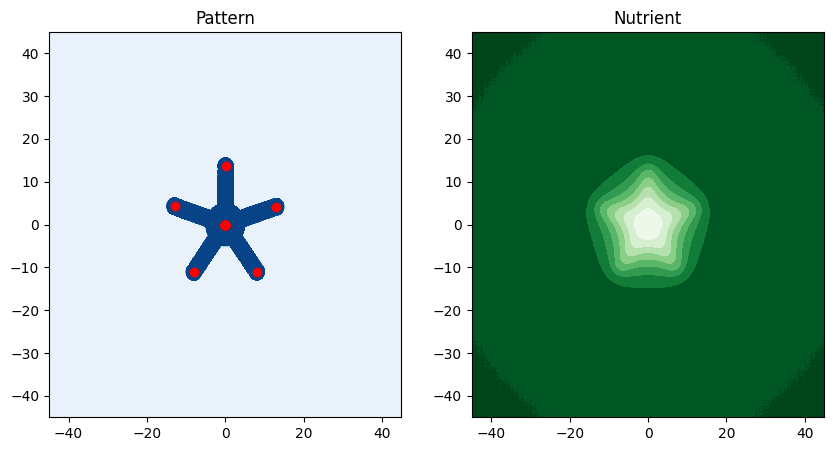

In [71]:
for i in range(0,  P.shape[0] , 10):

    #plt.contourf(XX, YY, N[i], vmin = 0, vmax = N0)
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10,5))
    ax1.scatter(swarm_array[i, :,0], swarm_array[i, :, 1], color = 'red', zorder = 10,)
    ax1.contourf(XX, YY, P[i], cmap = "Blues")
    ax1.set_title("Pattern")

    ax2.contourf(XX, YY, N[i], cmap = "Greens", vmin = 0, vmax = N0)
    ax2.set_title("Nutrient")
    plt.show()

    clear_output(wait = True)

In [20]:

# for i in range(0,N.shape[0],1):

#     ax = plt.subplot()
#     ax.set_ylim(0,10)
#     ax.plot(x, N[i,int(nx/2),:], color = 'green')

#     ax_twin = ax.twinx()
#     ax_twin.plot(x, C[i,int(nx/2),:], color = 'red')
#     ax_twin.set_ylim(0,10)
#     ax.axhline(1.0, -L/2, L/2, linestyle = '--')
    
#     plt.show()

#     clear_output(wait = True)

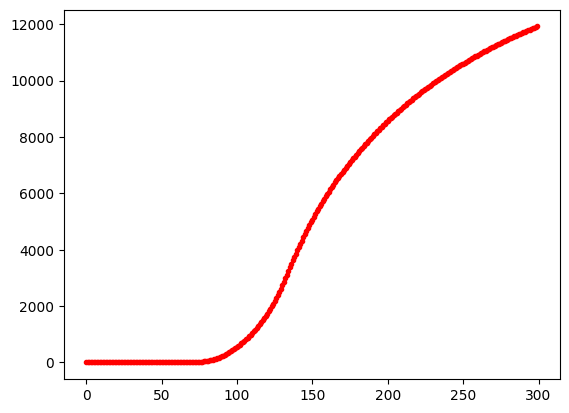

In [21]:
C_masses = jnp.sum(C, axis = (1,2))
plt.plot(C_masses, marker = '.', color = 'red')
plt.show()

In [22]:
# fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (12,4))

# ax1.contourf(N[:,int(nx/2),:], cmap = "Greens", levels = 30)
# ax2.contourf(C[:,int(nx/2),:], cmap = "Reds", levels = 30)
# ax3.contourf(P[:,int(nx/2),:], cmap = "Blues", levels = 30)
# plt.tight_layout()
# plt.show()

In [23]:
# swarm_array, swarm_mask = final_state.swarm_state

# plt.figure(figsize = (5,5))
# plt.scatter(swarm_array[:,0], swarm_array[:,1], color = 'red')
# plt.contourf(XX, YY, P[-1])
# plt.show()